In [1]:
import jax.numpy as jnp
import jax
import jaxdem as jd
jax.config.update("jax_enable_x64", True)
import numpy as np
import os
from bump_utils import create_clumps
import time
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

W0123 20:00:56.681757 1144888 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W0123 20:00:56.683828 1144744 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


In [11]:
skin = []
mu = []
overflow = []
builds = []
performance = []
radius = []
phi = []
phi_n = []
mean_occupancy = []
max_occupancy = []
predicted_max_occupancy = []
nl_cutoff = []

data_root = '/home/mmccraw/dev/data/26-01-01/grant/neighbor-list-characterization-3d/dynamics-1'
for name in os.listdir(data_root):
    path = os.path.join(data_root, name)
    try:
        state_traj = jd.utils.h5.load(os.path.join(path, 'state.h5'))
        system_traj = jd.utils.h5.load(os.path.join(path, 'system.h5'))
    except Exception as e:
        print(e)
        continue
    _, _mu, _, _skin = name.split('-')
    mu.append(float(_mu))
    skin.append(float(_skin))
    nl_cutoff.append(float(system_traj.collider.cutoff[0]) * (1.0 + float(_skin)))
    overflow.append(float(jnp.any(system_traj.collider.overflow)))
    builds.append(int(system_traj.collider.n_build_times[-1]))
    with open(os.path.join(path, 'stats.json'), 'r') as f:
        stats = json.load(f)
    performance.append(state_traj.N * stats['n_steps'] / stats['run_time'])
    radius.append(state_traj.rad.min())
    phi.append(float(jnp.sum(jnp.pi * state_traj.rad[0] ** state_traj.dim * ((1) if state_traj.dim == 2 else (4 / 3))) / jnp.prod(system_traj.domain.box_size[0])))
    phi_n.append(float(state_traj.N / jnp.prod(system_traj.domain.box_size[0])))
    occupancy = jnp.sum(system_traj.collider.neighbor_list != -1, axis=-1)
    mean_occupancy.append(jnp.mean(occupancy[occupancy != 0]))
    max_occupancy.append(jnp.max(occupancy))

    safety_factor = 1.2
    nl_volume = jnp.pi * (safety_factor * float(system_traj.collider.cutoff[0]) * (1.0 + float(_skin))) ** state_traj.dim * ((1) if state_traj.dim == 2 else (4 / 3))
    number_density = float(state_traj.N / jnp.prod(system_traj.domain.box_size[0]))
    occupancy = nl_volume * number_density
    predicted_max_occupancy.append(int(number_density * nl_volume) + 10)

    print(jnp.mean(jax.vmap(lambda st: jd.utils.thermal.compute_temperature(st, is_rigid=True, subtract_drift=True))(state_traj)))

df = pd.DataFrame({
    'skin': skin,
    'mu': mu,
    'overflow': overflow,
    'builds': builds,
    'performance': performance,
    'radius': radius,
    'phi': phi,
    'phi_n': phi_n,
    'max_occupancy': max_occupancy,
    'mean_occupancy': mean_occupancy,
    'predicted_max_occupancy': predicted_max_occupancy,
    'nl_cutoff': nl_cutoff,
})

0.00011311667860419789
9.396709211045105e-05
9.616626521539236e-05
0.00010220939372604444
0.00010054047256111575
9.34958089641184e-05
0.00010243892702817522
0.00010354821457988609
0.00012876028270078884
0.00010240715190725596
0.000109948842622728
9.652840941562061e-05
9.562905770013567e-05
0.0001001599230457826
9.620408504547126e-05
9.612313521351564e-05
9.710279979568425e-05
0.00010124875020019707
0.00010107223871780924
9.384078449494772e-05
9.641073472281256e-05
0.00010064397771025913
9.682297266535665e-05
8.724952258927554e-05


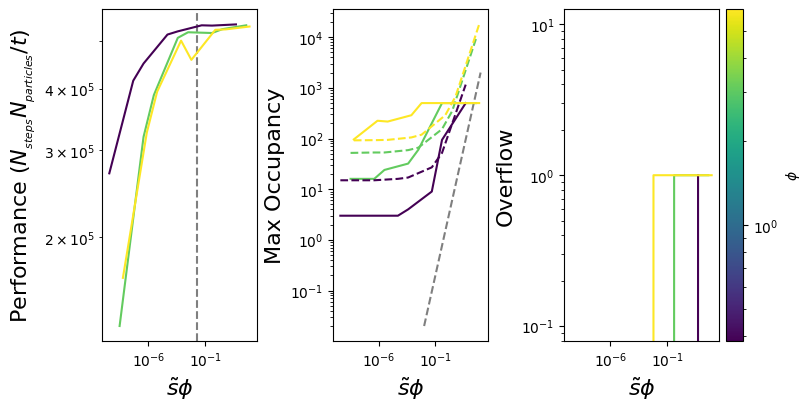

In [12]:
color_mu = False

if color_mu:
    norm = LogNorm(df.mu.min(), df.mu.max())
else:
    norm = LogNorm(df.phi.min(), df.phi.max())
cmap = plt.cm.viridis

fig, ax = plt.subplots(1, 3, figsize=(8, 4), constrained_layout=True)

for mu in df.mu.unique():
    mask = (df.mu == mu)
    _df = df[mask].sort_values(by='skin')
    if color_mu:
        c = cmap(norm(mu))
    else:
        c = cmap(norm(_df.phi.values[0]))
    x = _df.skin ** state_traj.dim * _df.phi
    # x = _df.nl_cutoff ** state.dim * _df.phi_n
    ax[0].plot(x, _df.performance, c=c)
    ax[1].plot(x, _df.max_occupancy, c=c)
    ax[1].plot(x, _df.predicted_max_occupancy, c=c, ls='--')
    ax[2].plot(x, _df.overflow, c=c)

sp = np.logspace(-2, 3, 10)
ax[1].plot(sp, 2 * sp, linestyle='--', color='k', alpha=0.5, zorder=0)

for a in ax:
    a.set_xscale('log')
    a.set_yscale('log')
    a.set_xlabel(r'$\tilde{s} \phi$', fontsize=16)
ax[0].set_ylabel(r'Performance ($N_{_{steps}} N_{_{particles}} / t$)', fontsize=16)
ax[1].set_ylabel('Max Occupancy', fontsize=16)
ax[2].set_ylabel('Overflow', fontsize=16)
ax[0].axvline(2e-2, linestyle='--', color='k', alpha=0.5, zorder=0)

sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
if color_mu:
    sm.set_array(np.unique(df.mu))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\mu_{eff}$')
else:
    sm.set_array(np.unique(df.phi.astype(float)))
    cbar = plt.colorbar(sm, ax=plt.gca(), label=r'$\phi$')

plt.savefig('nl-performance-3d.png')

Array(4.75182931e-08, dtype=float64)